link util: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 !!!!

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1879221877322878631]

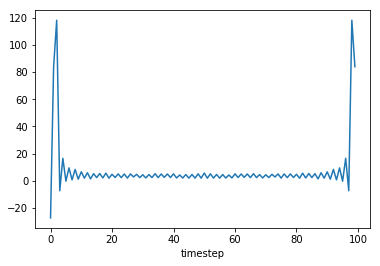

In [3]:
##probar con funcion seno
from random import randint
from scipy.signal import resample


def sine(X, signal_freq=60., add_noise=False, noise_range=(-0.1, 0.1),shifted=False):
    if shifted:
        ammount_shifted = randint(0, 100)
    else:
        ammount_shifted = 0

    if add_noise:
        if shifted:
            clean_signal = np.sin(2 * np.pi * (X[ammount_shifted:len(X)-100+ammount_shifted]) / signal_freq)
        else:
            clean_signal = np.sin(2 * np.pi * (X[:len(X)-100]) / signal_freq)                                    
        noisy_signal = clean_signal + np.random.uniform(noise_range[0], noise_range[1], size=clean_signal.shape)
        return noisy_signal
    else:
        if shifted:
            return np.sin(2 * np.pi * (X[ammount_shifted:len(X)-100+ammount_shifted]) / signal_freq)
        else:
            return np.sin(2 * np.pi * (X[:len(X)-100]) / signal_freq)
N = 5000
data1 = np.abs(np.fft.fft( sine(np.arange(N),add_noise=True,shifted=True) ))
import matplotlib.pyplot as plt
plt.plot(resample(data1,100))
plt.xlabel("timestep")
plt.show()

In [4]:
plt.plot(data[0])
plt.xlim(0)
plt.xlabel("timestep")
plt.show()

NameError: name 'data' is not defined

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

Sample de una secuencia mas corta

In [4]:
datos = []
N=500
for i in range(4000):
    funcion_seno = sine(np.arange(N),add_noise=True,shifted=True)
    #fourier = np.abs(np.fft.fft(funcion_seno))
    
    datos.append(funcion_seno)
    
data = np.vstack((datos))
data.shape

(4000, 400)

In [6]:
# normalize
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(data)
#data_scaled = scaler.transform(data)
data_scaled = (data+1)/2.0
data_scaled.shape

(4000, 400)

In [13]:
#para probar los timesteps.
X = np.reshape(data_scaled, (data_scaled.shape[0],data_scaled.shape[1]/10 ,10))
X.shape

(4000, 490, 10)

In [7]:
# reshape X to be [samples, time steps, features]
X = np.reshape(data_scaled, (data_scaled.shape[0],data_scaled.shape[1] ,1))
X.shape

(4000, 400, 1)

### RED:

In [8]:
from keras.layers import Input, LSTM, RepeatVector,GRU,Dense, Bidirectional
from keras.models import Model

timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

inputs = Input(shape=(timesteps, input_dim))
#return state...
#encoded = LSTM(latent_dim,return_sequences=True,activation='tanh')(inputs)

#stateful=True

#deeper
#encoded = LSTM(units = 10, return_sequences=True)(inputs) #probar sigmoid
encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid

encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

#encoder = LSTM(latent_dim,return_sequences=False,activation='relu',return_state=True)
#encoded,state_h,state_c = encoder(inputs) #tanh,sigmoid o relu
#state_h,state_c #para lstm

#PARTE DE EL MEDIO---
repeat_encoded = RepeatVector(timesteps)(encoded)

#initial_state=[state_h,state_c] $para lstm
#decoded = LSTM(input_dim, return_sequences=True,activation='sigmoid')
#decoded = decoded(repeat_encoded,initial_state=[state_h,state_c]) #cambiar  a sigmoid?

#decoded = LSTM(input_dim, return_sequences=True,activation='linear')(repeat_encoded)

#deeper
decoded = LSTM(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
#decoded = LSTM(10,return_sequences=True)(decoded)    #probar sigmoid
decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 


encoder = Model(inputs, encoded)
sequence_autoencoder = Model(inputs, decoded)
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 25)           2700      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                7424      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 400, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400, 25)           5800      
_________________________________________________________________
lstm_4 (LSTM)                (None, 400, 1)            108       
Total params: 16,032
Trainable params: 16,032
Non-trainable params: 0
_________________________________________________________________


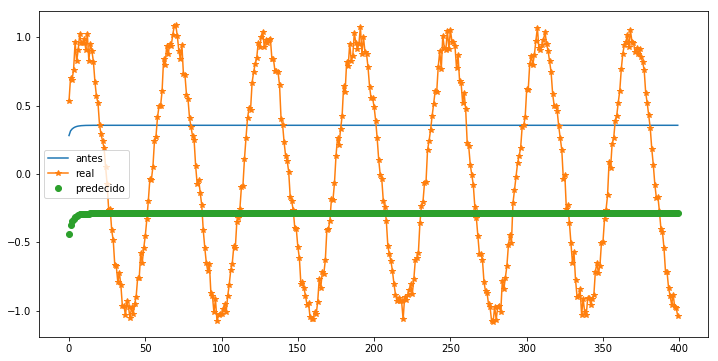

In [75]:
Xhat = sequence_autoencoder.predict(X[:10])
Xhat = np.reshape(Xhat,(Xhat.shape[0],Xhat.shape[1]))

#rarooo
Xhat_returned = Xhat*2-1 #scaler.inverse_transform(Xhat)

plt.figure(figsize=(12,6))
plt.plot(Xhat[0],label="antes")
plt.plot(data[0],'*-',label="real")
plt.plot(Xhat_returned[0],'o',label="predecido")

plt.legend()
#plt.xlim(0,1000)
plt.show()

In [66]:
encoder.predict(X)

array([[ 0.00391964, -0.00921255,  0.00258154, ...,  0.01093391,
         0.01754799, -0.00876773],
       [ 0.05119377, -0.00131275, -0.04444379, ...,  0.04983665,
         0.03304018, -0.03245191],
       [ 0.00923089, -0.00429381, -0.00248228, ...,  0.00797391,
         0.00539379, -0.00638279],
       ..., 
       [ 0.04951401, -0.00147194, -0.04099663, ...,  0.04588596,
         0.03020455, -0.02969105],
       [ 0.04447043, -0.00532889, -0.03487885, ...,  0.04742993,
         0.0360704 , -0.03191952],
       [ 0.01664655, -0.00443526, -0.00685584, ...,  0.01301872,
         0.00771714, -0.00955173]], dtype=float32)

In [82]:
with tf.device('/cpu:0'):
    sequence_autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    sequence_autoencoder.fit(X,X, epochs=50, batch_size=64) #autoencoder fit

Epoch 1/50
4000/4000 [==============================] - 70s - loss: 0.6976    
Epoch 2/50
4000/4000 [==============================] - 64s - loss: 0.6946    
Epoch 3/50
 384/4000 [=>............................] - ETA: 58s - loss: 0.6941

KeyboardInterrupt: 

Note that by default, the internal state of the network is reset after each batch, but more explicit control over when the internal state is reset can be achieved by using a so-called stateful LSTM and calling the reset operation manually.

In [86]:
sequence_autoencoder.compile(loss='binary_crossentropy', optimizer='adam') #o adam
#sequence_autoencoder.compile(loss='mse', optimizer='rmsprop') #o adam

for i in range(50):
    sequence_autoencoder.fit(X,X, epochs=1, batch_size=16) #autoencoder fit
    
    #sequence_autoencoder.reset_states()

Epoch 1/1
 496/4000 [==>...........................] - ETA: 170s - loss: 0.6929

KeyboardInterrupt: 

In [70]:
encoder.predict(X[:10])

array([[ 0.8361783 , -0.73884982, -0.79032087, -0.9937619 ,  1.        ,
         0.79468048,  0.78585857,  0.48382697, -0.78334951, -0.93785733,
        -0.10508078,  0.92063785, -0.78930295, -0.44883603, -0.46107125,
        -0.04550148, -0.88935918,  1.        , -0.56662202, -0.55895185,
         0.16502938,  0.24644433, -0.48501754, -0.74304706, -0.12028234,
         0.85787487,  0.3928588 ,  0.80820006,  1.        , -0.14897396,
         0.63049752, -0.69698817],
       [ 0.78656924, -0.70952284, -0.76106846, -0.95643789,  0.97598553,
         0.75985032,  0.74065673,  0.25712743, -0.73328412, -0.96856344,
        -0.05116834,  0.85167581, -0.75183648, -0.43832055, -0.43925563,
        -0.0399885 , -0.88998294,  1.        , -0.57690436, -0.5224818 ,
        -0.00859375,  0.2092956 , -0.40107274, -0.75136298, -0.1150777 ,
         0.8584643 ,  0.41591483,  0.83217061,  1.        , -0.08284137,
         0.6184321 , -0.65191561],
       [ 0.82973599, -0.74251616, -0.7839998 , -0.9995

In [57]:
import tensorflow as tf
from keras import backend as K
a = tf.convert_to_tensor(data[0], np.float32)
b = tf.convert_to_tensor(np.zeros(4900), np.float32)

aux = K.mean(K.binary_crossentropy(a,b),axis=-1)

tf.Session().run(aux)

1.3677408

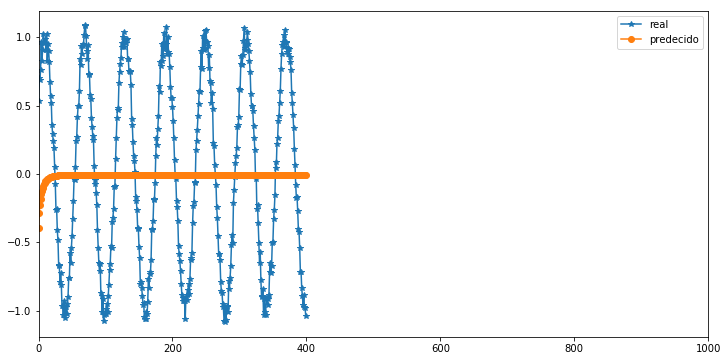

In [77]:
Xhat = sequence_autoencoder.predict(X[:10])
Xhat = np.reshape(Xhat,(Xhat.shape[0],Xhat.shape[1]*Xhat.shape[2]))

#rarooo
Xhat_returned = Xhat*2-1#scaler.inverse_transform(Xhat)

plt.figure(figsize=(12,6))
#plt.plot(Xhat[0],label="antes")
plt.plot(data[0],'*-',label="real")
plt.plot(Xhat_returned[0],'o-',label="predecido")

plt.legend()
plt.xlim(0,1000)
plt.show()

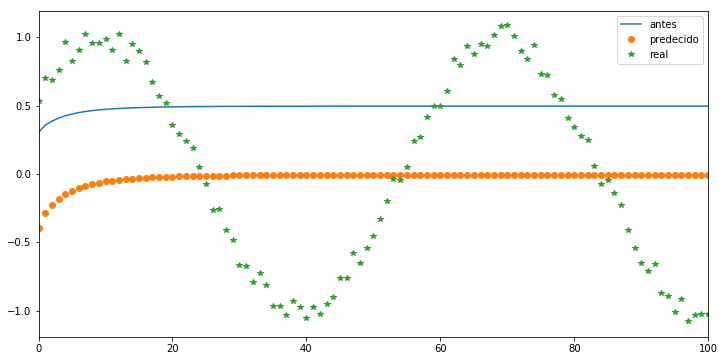

In [83]:
plt.figure(figsize=(12,6))
plt.plot(Xhat[0],label="antes")
plt.plot(Xhat_returned[0],'o',label="predecido")
plt.plot(data[0],'*',label="real")
plt.legend()
plt.xlim(0,100)
plt.show()

### Maquinas a probar

In [9]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder

print("---MODELO 1 (SIGMOID) CON 16 BATCH")
model1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model1.fit(X,X, epochs=1, batch_size=16) #autoencoder fit
    
print("---MODELO 1 (SIGMOID) CON 64 BATCH")
model1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model1.fit(X,X, epochs=1, batch_size=64) #autoencoder fit

---MODELO 1 (SIGMOID) CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 184s - loss: 0.6943   
Epoch 1/1
4000/4000 [==============================] - 174s - loss: 0.6907   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6884   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6842   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6917   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6933   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 184s - loss: 0.6926   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6911   
Epoch 1/1
4000/4000 [==============================] - 174s - loss: 0.6877   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6856   
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6812   
Epoch 1/1
4000/4000 [========

In [10]:
def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='tanh')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder

print("---MODELO 2 (TANH) CON 16 BATCH")
model2 = def_model()
model2.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model2.fit(X,X, epochs=1, batch_size=16) #autoencoder fit
    
print("---MODELO 2 (TANH) CON 64 BATCH")
model2 = def_model()
model2.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model2.fit(X,X, epochs=1, batch_size=64) #autoencoder fit

---MODELO 2 (TANH) CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 173s - loss: 0.6964   
Epoch 1/1
4000/4000 [==============================] - 171s - loss: 0.6927   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6845   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6696   
Epoch 1/1
4000/4000 [==============================] - 168s - loss: 0.6735   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6944   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6935   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6927   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6899   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6848   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.6544   
Epoch 1/1
4000/4000 [==============================] - 169s - loss: 0.5990   
Epoch 1/1
4000/4000 [===========

In [11]:
def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 5, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='tanh')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(5,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder

print("---MODELO 3 (TANH-chico) CON 16 BATCH")
model3 = def_model()
model3.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model3.fit(X,X, epochs=1, batch_size=16) #autoencoder fit
    
print("---MODELO 3 (TANH-chico) CON 64 BATCH")
model3 = def_model()
model3.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model3.fit(X,X, epochs=1, batch_size=64) #autoencoder fit

---MODELO 3 (TANH-chico) CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 161s - loss: 0.6999   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6935   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6931   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6931   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6924   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6918   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6918   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6920   
Epoch 1/1
4000/4000 [==============================] - 159s - loss: 0.6917   
Epoch 1/1
4000/4000 [==============================] - 160s - loss: 0.6920   
Epoch 1/1
4000/4000 [==============================] - 160s - loss: 0.6915   
Epoch 1/1
4000/4000 [=====

In [12]:
def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(units = 5, return_sequences=True,dropout=0.2)(encoded) #probar sigmoid
    
    encoded = LSTM(latent_dim, return_sequences=False, activation='tanh')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)
    
    decoded = LSTM(5,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(25,return_sequences=True,dropout=0.2)(decoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder

    
print("---MODELO 4 (TANH.profunda) CON 64 BATCH")
model4 = def_model()
model4.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model4.fit(X,X, epochs=1, batch_size=64) #autoencoder fit
    
print("---MODELO 2 (TANH-profunda) CON 16 BATCH")
model4 = def_model()
model4.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model4.fit(X,X, epochs=1, batch_size=16) #autoencoder fit

---MODELO 4 (TANH.profunda) CON 64 BATCH
Epoch 1/1
4000/4000 [==============================] - 90s - loss: 0.7039    
Epoch 1/1
4000/4000 [==============================] - 101s - loss: 0.6951   
Epoch 1/1
4000/4000 [==============================] - 106s - loss: 0.6943   
Epoch 1/1
4000/4000 [==============================] - 97s - loss: 0.6931    
Epoch 1/1
4000/4000 [==============================] - 107s - loss: 0.6929   
Epoch 1/1
4000/4000 [==============================] - 99s - loss: 0.6937    
Epoch 1/1
4000/4000 [==============================] - 96s - loss: 0.6923    
Epoch 1/1
4000/4000 [==============================] - 102s - loss: 0.6906   
Epoch 1/1
4000/4000 [==============================] - 97s - loss: 0.6949    
Epoch 1/1
4000/4000 [==============================] - 96s - loss: 0.6936    
Epoch 1/1
4000/4000 [==============================] - 96s - loss: 0.6935    
Epoch 1/1
4000/4000 [==============================] - 105s - loss: 0.6934   
Epoch 1/1
4000/4000 [==

KeyboardInterrupt: 

### MEjor red, experimentar con distintas neuronas

In [13]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO 1 (SIGMOID) CON 16 BATCH")
model1,encoder1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
hist = model1.fit(X,X, epochs=50, batch_size=16) #autoencoder fit

---MODELO 1 (SIGMOID) CON 16 BATCH
Epoch 1/50
4000/4000 [==============================] - 209s - loss: 0.6943   
Epoch 2/50
4000/4000 [==============================] - 189s - loss: 0.6918   
Epoch 3/50
4000/4000 [==============================] - 186s - loss: 0.6911   
Epoch 4/50
4000/4000 [==============================] - 186s - loss: 0.6932   
Epoch 5/50
4000/4000 [==============================] - 181s - loss: 0.6933   
Epoch 6/50
4000/4000 [==============================] - 182s - loss: 0.6931   
Epoch 7/50
4000/4000 [==============================] - 174s - loss: 0.6930   
Epoch 8/50
4000/4000 [==============================] - 174s - loss: 0.6927   
Epoch 9/50
4000/4000 [==============================] - 174s - loss: 0.6889   
Epoch 10/50
4000/4000 [==============================] - 174s - loss: 0.6821   
Epoch 11/50
4000/4000 [==============================] - 174s - loss: 0.6749   
Epoch 12/50
4000/4000 [==============================] - 174s - loss: 0.6601   
Epoch 13/50
40

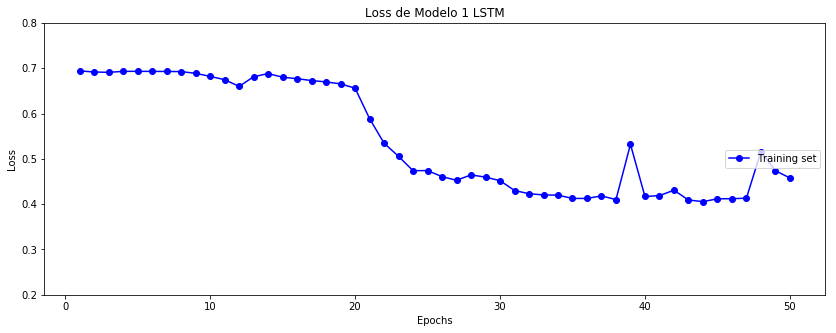

In [14]:
history_dict1 = hist.history
loss_values1 = history_dict1['loss']
#val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
#axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Loss de Modelo 1 LSTM')
axarr.set_ylim(0.2,.8)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

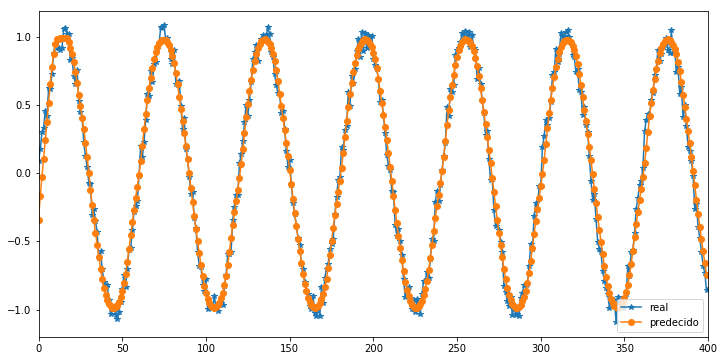

In [10]:
#visualizarlo
Xhat = model1.predict(X[:10])
Xhat = np.reshape(Xhat,(Xhat.shape[0],Xhat.shape[1]*Xhat.shape[2]))

#rarooo
Xhat_returned = Xhat*2-1#scaler.inverse_transform(Xhat)

plt.figure(figsize=(12,6))
#plt.plot(Xhat[0],label="antes")
plt.plot(data[0],'*-',label="real")
plt.plot(Xhat_returned[0],'o-',label="predecido")

plt.legend()
plt.xlim(0,400)
plt.show()

Menos capas --> **no resulto**

In [8]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 64 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(inputs)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(repeat_encoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO 1 (SIGMOID) CON 16 BATCH")
model1,encoder1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model1.fit(X,X, epochs=1, batch_size=16) #autoencoder fit

---MODELO 1 (SIGMOID) CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 104s - loss: 0.6936   
Epoch 1/1
4000/4000 [==============================] - 99s - loss: 0.6931    
Epoch 1/1
4000/4000 [==============================] - 101s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 110s - loss: 0.6928   
Epoch 1/1
4000/4000 [==============================] - 103s - loss: 0.6928   
Epoch 1/1
4000/4000 [==============================] - 118s - loss: 0.6928   
Epoch 1/1
4000/4000 [==============================] - 105s - loss: 0.6927   
Epoch 1/1
4000/4000 [==============================] - 104s - loss: 0.6921   
Epoch 1/1
4000/4000 [==============================] - 108s - loss: 0.6911   
Epoch 1/1
4000/4000 [==============================] - 108s - loss: 0.6908   
Epoch 1/1
4000/4000 [==============================] - 103s - loss: 0.6907   
Epoch 1/1
4000/4000 [==============================] - 97s - loss: 0.6907    
Epoch 1/1
4000/4000 [========

Menos neuronas --> **NO RESULTO**

In [12]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 5, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(5,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO MENOS NEURONAS CON 16 BATCH")
model1,encoder1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model1.fit(X,X, epochs=1, batch_size=16) #autoencoder fit

---MODELO MENOS NEURONAS CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 195s - loss: 0.6950   
Epoch 1/1
4000/4000 [==============================] - 195s - loss: 0.6936   
Epoch 1/1
4000/4000 [==============================] - 175s - loss: 0.6935   
Epoch 1/1
4000/4000 [==============================] - 177s - loss: 0.6932   
Epoch 1/1
4000/4000 [==============================] - 188s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 188s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 187s - loss: 0.6930   
Epoch 1/1
4000/4000 [==============================] - 195s - loss: 0.6929   
Epoch 1/1
4000/4000 [==============================] - 184s - loss: 0.6922   
Epoch 1/1
4000/4000 [==============================] - 193s - loss: 0.6915   
Epoch 1/1
4000/4000 [==============================] - 188s - loss: 0.6912   
Epoch 1/1
4000/4000 [==============================] - 188s - loss: 0.6906   
Epoch 1/1
4000/4000 [=====

KeyboardInterrupt: 

Mas neuronas -->> **bien, pero demora en entrnear**

In [9]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 50, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(50,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder

print("---MODELO MAS NEURONAS CON 16 BATCH")
model1 = def_model()
model1.compile(loss='binary_crossentropy', optimizer='adam') #o adam
for i in range(50):
    model1.fit(X,X, epochs=1, batch_size=16) #autoencoder fit

---MODELO MAS NEURONAS CON 16 BATCH
Epoch 1/1
4000/4000 [==============================] - 197s - loss: 0.6950   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6928   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6905   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6894   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6722   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6653   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.6566   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.5468   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.4829   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.4672   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.4758   
Epoch 1/1
4000/4000 [==============================] - 191s - loss: 0.4573   
Epoch 1/1
4000/4000 [=======

In [ ]:
hist

Profunda --> **bien, pero demora en entrenar**

In [17]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = LSTM(units = 5, return_sequences=True)(inputs) #probar sigmoid
    encoded = LSTM(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)
    
    decoded = LSTM(5,return_sequences=True)(repeat_encoded)    #probar sigmoid
    decoded = LSTM(25,return_sequences=True,dropout=0.2)(decoded)    #probar sigmoid
    decoded = LSTM(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO PROFUNDA CON 16 BATCH")
model1_deep,encoder1_deep = def_model()
model1_deep.compile(loss='binary_crossentropy', optimizer='adam') #o adam
hist = model1_deep.fit(X,X, epochs=50, batch_size=16) #autoencoder fit

---MODELO PROFUNDA CON 16 BATCH
Epoch 1/50
4000/4000 [==============================] - 208s - loss: 0.6975   
Epoch 2/50
4000/4000 [==============================] - 206s - loss: 0.6938   
Epoch 3/50
4000/4000 [==============================] - 205s - loss: 0.6936   
Epoch 4/50
4000/4000 [==============================] - 205s - loss: 0.6934   
Epoch 5/50
4000/4000 [==============================] - 205s - loss: 0.6932   
Epoch 6/50
4000/4000 [==============================] - 205s - loss: 0.6924   
Epoch 7/50
4000/4000 [==============================] - 205s - loss: 0.6873   
Epoch 8/50
4000/4000 [==============================] - 205s - loss: 0.6844   
Epoch 9/50
4000/4000 [==============================] - 205s - loss: 0.6888   
Epoch 10/50
4000/4000 [==============================] - 205s - loss: 0.6850   
Epoch 11/50
4000/4000 [==============================] - 205s - loss: 0.6859   
Epoch 12/50
4000/4000 [==============================] - 205s - loss: 0.6784   
Epoch 13/50
4000/

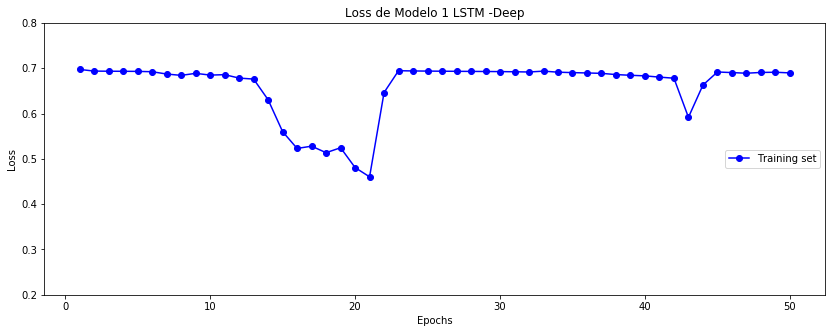

In [18]:
history_dict1_deep = hist.history
loss_values1 = history_dict1_deep['loss']
#val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
#axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Loss de Modelo 1 LSTM -Deep')
axarr.set_ylim(0.2,.8)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

Gated Recurrent unit (GRUs) --> **bien**

In [9]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = GRU(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = GRU(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = GRU(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = GRU(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO GRU (SIGMOID) CON 16 BATCH")
modelgru,encodergru = def_model()
modelgru.compile(loss='binary_crossentropy', optimizer='adam') #o adam
hist = modelgru.fit(X,X, epochs=50, batch_size=16) #autoencoder fit

---MODELO GRU (SIGMOID) CON 16 BATCH
Epoch 1/50
4000/4000 [==============================] - 152s - loss: 0.6944   
Epoch 2/50
4000/4000 [==============================] - 148s - loss: 0.6910   
Epoch 3/50
4000/4000 [==============================] - 146s - loss: 0.6850   
Epoch 4/50
4000/4000 [==============================] - 144s - loss: 0.6780   
Epoch 5/50
4000/4000 [==============================] - 142s - loss: 0.6797   
Epoch 6/50
4000/4000 [==============================] - 139s - loss: 0.6523   
Epoch 7/50
4000/4000 [==============================] - 139s - loss: 0.5812   
Epoch 8/50
4000/4000 [==============================] - 139s - loss: 0.5027   
Epoch 9/50
4000/4000 [==============================] - 144s - loss: 0.4690   
Epoch 10/50
4000/4000 [==============================] - 147s - loss: 0.4447   
Epoch 11/50
4000/4000 [==============================] - 147s - loss: 0.4425   
Epoch 12/50
4000/4000 [==============================] - 144s - loss: 0.4393   
Epoch 13/50


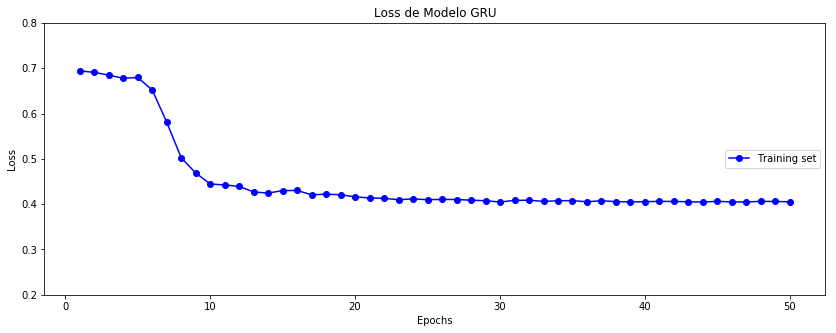

In [12]:
history_dictgru = hist.history
loss_values1 = history_dictgru['loss']
#val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
#axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Loss de Modelo GRU')
axarr.set_ylim(0.2,.8)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

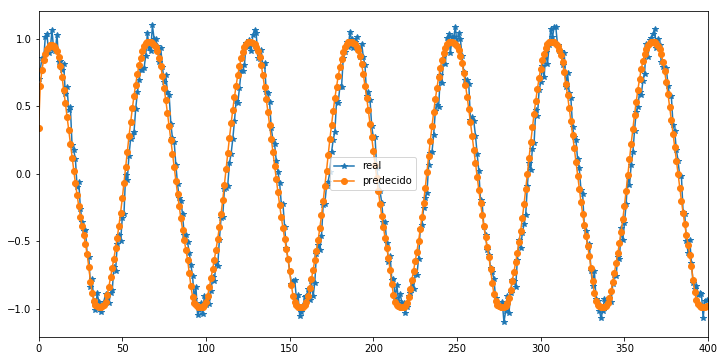

In [12]:
#visualizarlo
Xhat = modelgru.predict(X[:10])
Xhat = np.reshape(Xhat,(Xhat.shape[0],Xhat.shape[1]*Xhat.shape[2]))

#rarooo
Xhat_returned = Xhat*2-1#scaler.inverse_transform(Xhat)

plt.figure(figsize=(12,6))
#plt.plot(Xhat[0],label="antes")
plt.plot(data[0],'*-',label="real")
plt.plot(Xhat_returned[0],'o-',label="predecido")

plt.legend()
plt.xlim(0,400)
plt.show()

gru (profunda) o con mas neuronas

In [15]:
timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = GRU(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = GRU(units = 5, return_sequences=True)(inputs) #probar sigmoid
    encoded = GRU(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)
    
    decoded = GRU(5,return_sequences=True)(repeat_encoded)    #probar sigmoid
    decoded = GRU(25,return_sequences=True,dropout=0.2)(decoded)    #probar sigmoid
    decoded = GRU(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO PROFUNDA CON 16 BATCH")
modelgru_deep, encodergru_deep= def_model()
modelgru_deep.compile(loss='binary_crossentropy', optimizer='adam') #o adam
hist = modelgru_deep.fit(X,X, epochs=50, batch_size=16) #autoencoder fit

---MODELO PROFUNDA CON 16 BATCH
Epoch 1/50
4000/4000 [==============================] - 161s - loss: 0.6939   
Epoch 2/50
4000/4000 [==============================] - 160s - loss: 0.6925   
Epoch 3/50
4000/4000 [==============================] - 160s - loss: 0.6882   
Epoch 4/50
4000/4000 [==============================] - 160s - loss: 0.6577   
Epoch 5/50
4000/4000 [==============================] - 160s - loss: 0.5170   
Epoch 6/50
4000/4000 [==============================] - 160s - loss: 0.4569   
Epoch 7/50
4000/4000 [==============================] - 160s - loss: 0.4314   
Epoch 8/50
4000/4000 [==============================] - 160s - loss: 0.4267   
Epoch 9/50
4000/4000 [==============================] - 160s - loss: 0.4237   
Epoch 10/50
4000/4000 [==============================] - 159s - loss: 0.4156   
Epoch 11/50
4000/4000 [==============================] - 159s - loss: 0.4134   
Epoch 12/50
4000/4000 [==============================] - 159s - loss: 0.4131   
Epoch 13/50
4000/

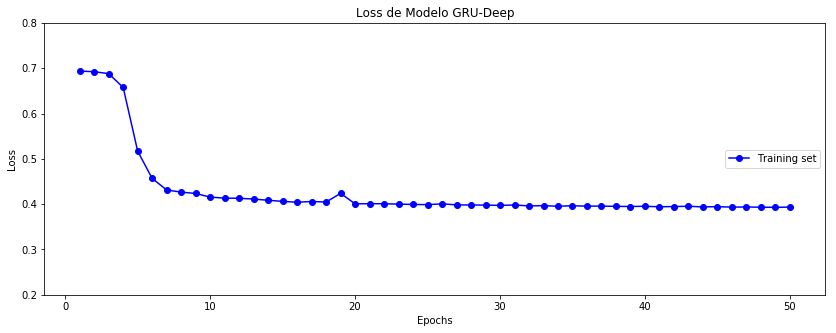

In [16]:
history_dictgru_deep = hist.history
loss_values1 = history_dictgru_deep['loss']
#val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
#axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Loss de Modelo GRU-Deep')
axarr.set_ylim(0.2,.8)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

#hacer los plot de history..

## Secuencia mas larga 

In [14]:
datos = []
N=15000
for i in range(4000):
    funcion_seno = sine(np.arange(N),add_noise=True,shifted=True)    
    datos.append(funcion_seno)
    
data = np.vstack((datos))
data_scaled = (data+1)/2.0
X = np.reshape(data_scaled, (data_scaled.shape[0],data_scaled.shape[1] ,1))
X.shape

(4000, 14900, 1)

In [ ]:
from keras.layers import Input, LSTM, RepeatVector,GRU,Dense, Bidirectional
from keras.models import Model

timesteps= X.shape[1]
input_dim = X.shape[2]
latent_dim = 32 # aumentar esto... 128

def def_model():
    inputs = Input(shape=(timesteps, input_dim))

    encoded = GRU(units = 25, return_sequences=True,dropout=0.2)(inputs) #probar sigmoid
    encoded = GRU(latent_dim, return_sequences=False, activation='sigmoid')(encoded)

    #PARTE DE EL MEDIO---
    repeat_encoded = RepeatVector(timesteps)(encoded)

    decoded = GRU(25,return_sequences=True,dropout=0.2)(repeat_encoded)    #probar sigmoid
    decoded = GRU(input_dim,return_sequences=True, activation='sigmoid')(decoded) 

    encoder = Model(inputs, encoded)
    sequence_autoencoder = Model(inputs, decoded)
    return sequence_autoencoder,encoder

print("---MODELO GRU (SIGMOID) CON 16 BATCH")
modelgru,encodergru = def_model()
modelgru.compile(loss='binary_crossentropy', optimizer='adam') #o adam

hist = modelgru.fit(X,X, epochs=50, batch_size=16) #autoencoder fit

In [ ]:
# mas o menos neuronas

In [ ]:
#mas profunda